In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score,precision_score, recall_score, f1_score,mean_absolute_error, mean_squared_error,precision_recall_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from xgboost import cv

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
#load & view the data
df = pd.read_csv('output/pec_prep_out.csv')
df=df.drop([ "Unnamed: 0"], axis=1)

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
# dropping uninformative features
colsToDelete = ['Année demande','Année Accident','Nom et Prénom Assuré /Raison Sociale',
       'Immatriculation Véhicule assuré','Nom et Prénom tiers /Raison Sociale','Immatriculation tiers', 
       'Numero sinistre', 'Numéro de contrat','Date de création','Date Accident','Date acceptation','Date accord (SST)' ,'Date demande']
df = df.drop(columns = colsToDelete, axis=1)


In [ ]:
df.shape

In [ ]:
threshold = 0.97
# calculate correlations
corr_matrix = df.corr().abs()
# get the upper part of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# columns with correlation above threshold
redundent = [column for column in upper.columns if any(upper[column] >= threshold)]
print(f'Columns to drop with correlation > {threshold}: {redundent}')
df.drop(columns=redundent, inplace=True)

In [ ]:
y = df["Fraud"].map({"Non":0, "Oui":1})
X = df.drop("Fraud", axis=1)

In [ ]:
le = LabelEncoder()
for i in  (X.columns):  
    le.fit(X[i].astype(str))
    X[i] = le.transform(X[i].astype(str))

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
# train test split data
testsize=0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=0)

In [ ]:
params = {
#             'objective':'binary:logistic',
#             'eval_metric':'error',
#             'max_depth': 100,
#             'alpha': 20,
#             'learning_rate': 1.0,
#             'n_estimators':100
        }
            
            
            
# instantiate the classifier 
model = XGBClassifier(objective='binary:logistic',learning_rate=0.1, max_depth=3,
                      colsample_bytree=1, n_estimators=100,subsample=1,booster='gbtree')

# fit the classifier to the training data
model.fit(X_train, y_train)
print(model)

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

In [ ]:
# make predictions on test data
y_pred = model.predict(X_test)

In [ ]:
for metric in [accuracy_score,precision_score,recall_score,f1_score,mean_absolute_error,mean_squared_error]:
            print(f'{metric.__name__}: {round(metric(y_test, y_pred), 4)}')

In [ ]:
kfold = KFold(n_splits=10, random_state=7)
accuracy = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
roc_auc = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')

print('Cross-validation Accuracy score: ', round(accuracy.mean(),4))
print('Cross-validation AUC score: ', round(roc_auc.mean(),4)) 

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
preds = cross_val_predict(model, X, y, cv=10)
conf_mat = confusion_matrix(y, preds)
conf_mat

In [ ]:
class_names=['legitimate', 'fraud']
plot_confusion_matrix(model, X_test, y_test,display_labels=class_names,cmap="YlGnBu")
plt.savefig('figure_EDA/confMatXGB.png',dpi=400,bbox_inches='tight')
plt.show()

In [ ]:
# titles_options = [("Confusion matrix, without normalization", None),
#                   ("Normalized confusion matrix", 'true')]
# for title, normalize in titles_options:
#     disp = plot_confusion_matrix(model, X_test, y_test,
#                                  display_labels=class_names,
#                                  cmap="YlGnBu",
#                                  normalize=normalize)
#     disp.ax_.set_title(title)

#     print(title)
#     print(disp.confusion_matrix)

# plt.show()

In [ ]:
metrics.plot_roc_curve(model, X_test, y_test) 
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.savefig('figure_EDA/rocXGB.png',dpi=400,bbox_inches='tight')
plt.show() 

In [ ]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [12, 8]
plt.savefig('figure_EDA/plot_importance.png',dpi=400,bbox_inches='tight')
plt.show()

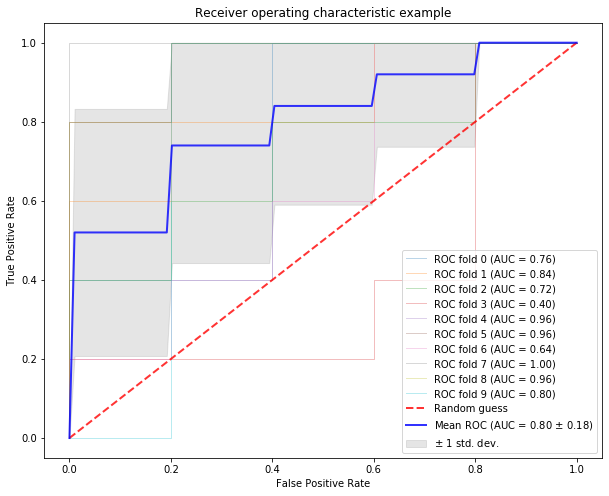

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10, 8))
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Random guess', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
# plt.show()
plt.savefig('figure_EDA/rocCrossval.png',dpi=1000,bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.externals import joblib
joblib.dump(model, 'model/xgb_model.pkl')

In [ ]:
model_columns= list(X.columns)
print(model_columns)
joblib.dump(model_columns, 'model/model_columns.pkl')

In [ ]:
import model_evaluation_utils as meu

meu.display_model_performance_metrics(y_test, y_pred, classes=[0,1])


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(model, X, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

In [ ]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(model, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(model, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(model, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")